In [1]:
"""
Over the air domain adaptation.

4 Modulations: bpsk, qpsk, 16qam and 16apsk.
Source SNR as 24, target from 10 to 22.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/ota_X.npy")
Y = np.load(file_path + "/ota_Y.npy")

sou_snr = 24
tar_snr = 10

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 3
lr = 0.002

for i in range(7):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=base.CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=25, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)
    
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    
    tar_snr += 2

In [ ]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()


x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Base
class CLDNN(nn.Module):
    def __init__(self, output_dim=4):
        super(CLDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
        # After conv1 and pooling: input length 4096 becomes 4089 then 2044 after pooling.
        # So the flattened output from the LSTM will be 2044 * 64.
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # x has shape: (batch, 2, 4096)
        x = self.conv1(x)      # -> (batch, 64, 4089)
        x = self.pool(x)       # -> (batch, 64, 2044)
        
        # Permute to have sequence first: (batch, 2044, 64)
        x = x.permute(0, 2, 1)
        
        x, _ = self.lstm1(x)   # -> (batch, 2044, 64)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)   # -> (batch, 2044, 64)
        x = self.dropout2(x)
        
        # Flatten: (batch, 2044*64)
        x = x.contiguous().view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
#%% DANN
from torch.autograd import Function
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

def grad_reverse(x, alpha=1.0):
    return ReverseLayerF.apply(x, alpha)
class CLDNN_FA(nn.Module):
    def __init__(self):
        super(CLDNN_FA, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        return x

class CLDNN_LP(nn.Module):
    def __init__(self, output_dim=7):
        super(CLDNN_LP, self).__init__()
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CLDNN_DC(nn.Module):
    def __init__(self):
        super(CLDNN_DC, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, alpha):
        x = ReverseLayerF.apply(x, alpha)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# star
class STAR_G(nn.Module):
    def __init__(self):
        super(STAR_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x

class STAR_C(nn.Module):
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20, init='kaiming_u', use_init=False):
        super(STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        self.fc1 = nn.Linear(2044 * 64, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            all_parameters = [self.mu2, self.sigma2]
            for item in all_parameters:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)

            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])

                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs


#%% mcd
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

class MCD_G(nn.Module):
    def __init__(self):
        super(MCD_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x
    
class MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(MCD_C, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Run 1/3
Epoch [1/50], Class Loss: 3.2449, Discrepancy Loss: 0.0851
Validation Loss: 1.2299
Epoch [2/50], Class Loss: 1.1931, Discrepancy Loss: 0.0365
Validation Loss: 1.0637
Epoch [3/50], Class Loss: 1.1135, Discrepancy Loss: 0.0389
Validation Loss: 1.0070
Epoch [4/50], Class Loss: 1.0245, Discrepancy Loss: 0.0633
Validation Loss: 1.1558
Epoch [5/50], Class Loss: 1.0137, Discrepancy Loss: 0.1024
Validation Loss: 2.2449
Epoch [6/50], Class Loss: 0.8495, Discrepancy Loss: 0.0696
Validation Loss: 0.8897
Epoch [7/50], Class Loss: 0.3697, Discrepancy Loss: 0.0698
Validation Loss: 0.1339
Epoch [8/50], Class Loss: 0.1969, Discrepancy Loss: 0.1218
Validation Loss: 0.0216
Epoch [9/50], Class Loss: 0.1892, Discrepancy Loss: 0.0849
Validation Loss: 0.1134
Epoch [10/50], Class Loss: 0.3929, Discrepancy Loss: 0.0532
Validation Loss: 0.0221
Epoch [11/50], Class Loss: 0.0118, Discrepancy Loss: 0.0255
Validation Loss: 0.0085
Epoch [12/50], Class Loss: 0.0057, Discrepancy Loss: 0.0270
Validation Loss:

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.8542, Train Acc: 0.5967, Val Loss: 0.5359, Val Acc: 0.7134
Epoch 2/50, Train Loss: 0.5649, Train Acc: 0.7092, Val Loss: 0.7700, Val Acc: 0.6109
Epoch 3/50, Train Loss: 0.4989, Train Acc: 0.7493, Val Loss: 0.5137, Val Acc: 0.7530
Epoch 4/50, Train Loss: 0.3831, Train Acc: 0.8392, Val Loss: 0.2751, Val Acc: 0.9466
Epoch 5/50, Train Loss: 0.3187, Train Acc: 0.9364, Val Loss: 15.5301, Val Acc: 0.4041
Epoch 6/50, Train Loss: 0.9723, Train Acc: 0.8863, Val Loss: 0.0084, Val Acc: 0.9976
Epoch 7/50, Train Loss: 0.0876, Train Acc: 0.9754, Val Loss: 0.0061, Val Acc: 0.9994
Epoch 8/50, Train Loss: 0.0050, Train Acc: 0.9981, Val Loss: 0.0194, Val Acc: 0.9922
Epoch 9/50, Train Loss: 0.0018, Train Acc: 0.9994, Val Loss: 0.0039, Val Acc: 0.9970
Epoch 10/50, Train Loss: 0.0038, Train Acc: 0.9984, Val Loss: 0.0016, Val Acc: 0.9994
Epoch 11/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.0049, Train Acc: 0.5462, Val Loss: 0.5353, Val Acc: 0.7038
Epoch 2/50, Train Loss: 0.5434, Train Acc: 0.7166, Val Loss: 0.5100, Val Acc: 0.7320
Epoch 3/50, Train Loss: 0.5002, Train Acc: 0.7460, Val Loss: 0.4629, Val Acc: 0.7530
Epoch 4/50, Train Loss: 0.4768, Train Acc: 0.7854, Val Loss: 0.4125, Val Acc: 0.8963
Epoch 5/50, Train Loss: 0.2219, Train Acc: 0.9234, Val Loss: 0.0968, Val Acc: 0.9646
Epoch 6/50, Train Loss: 0.0238, Train Acc: 0.9925, Val Loss: 0.0287, Val Acc: 0.9910
Epoch 7/50, Train Loss: 0.0267, Train Acc: 0.9924, Val Loss: 0.0076, Val Acc: 0.9970
Epoch 8/50, Train Loss: 0.0289, Train Acc: 0.9948, Val Loss: 0.0050, Val Acc: 0.9982
Epoch 9/50, Train Loss: 0.0804, Train Acc: 0.9793, Val Loss: 0.0584, Val Acc: 0.9796
Epoch 10/50, Train Loss: 0.0085, Train Acc: 0.9973, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.3502, Domain Loss: 2.1100, Class Loss: 2.2402
Epoch 2/50, Loss: 2.2525, Domain Loss: 1.2679, Class Loss: 0.9846
Epoch 3/50, Loss: 1.9047, Domain Loss: 1.3159, Class Loss: 0.5888
Epoch 4/50, Loss: 1.7187, Domain Loss: 1.1374, Class Loss: 0.5813
Epoch 5/50, Loss: 1.5824, Domain Loss: 1.0378, Class Loss: 0.5446
Epoch 6/50, Loss: 1.4486, Domain Loss: 0.9279, Class Loss: 0.5208
Epoch 7/50, Loss: 1.3580, Domain Loss: 0.8333, Class Loss: 0.5247
Epoch 8/50, Loss: 1.3079, Domain Loss: 0.7564, Class Loss: 0.5515
Epoch 9/50, Loss: 1.3369, Domain Loss: 0.7445, Class Loss: 0.5924
Epoch 10/50, Loss: 1.4962, Domain Loss: 0.8564, Class Loss: 0.6398
Epoch 11/50, Loss: 1.8639, Domain Loss: 1.0964, Class Loss: 0.7675
Epoch 12/50, Loss: 1.4568, Domain Loss: 0.8699, Class Loss: 0.5869
Epoch 13/50, Loss: 1.3752, Domain Loss: 0.8232, Class Loss: 0.5519
Epoch 14/50, Loss: 1.2752, Domain Loss: 0.7733, Class Loss: 0.5018
Epoch 15/50, Loss: 1.3074, Domain Loss: 0.7684, Class Loss: 0.5390
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.4054, Domain Loss: 2.2507, Class Loss: 2.1546
Epoch 2/50, Loss: 2.3481, Domain Loss: 1.2788, Class Loss: 1.0693
Epoch 3/50, Loss: 1.8073, Domain Loss: 1.1983, Class Loss: 0.6090
Epoch 4/50, Loss: 1.7747, Domain Loss: 1.2101, Class Loss: 0.5646
Epoch 5/50, Loss: 1.6120, Domain Loss: 1.0091, Class Loss: 0.6029
Epoch 6/50, Loss: 1.3904, Domain Loss: 0.8364, Class Loss: 0.5540
Epoch 7/50, Loss: 1.3905, Domain Loss: 0.8528, Class Loss: 0.5377
Epoch 8/50, Loss: 1.6302, Domain Loss: 0.9889, Class Loss: 0.6412
Epoch 9/50, Loss: 1.6598, Domain Loss: 1.0132, Class Loss: 0.6466
Epoch 10/50, Loss: 1.4994, Domain Loss: 0.9307, Class Loss: 0.5687
Epoch 11/50, Loss: 2.8461, Domain Loss: 1.4663, Class Loss: 1.3798
Epoch 12/50, Loss: 2.8931, Domain Loss: 1.6807, Class Loss: 1.2124
Epoch 13/50, Loss: 1.9416, Domain Loss: 1.2238, Class Loss: 0.7178
Epoch 14/50, Loss: 1.6737, Domain Loss: 1.0411, Class Loss: 0.6327
Epoch 15/50, Loss: 1.5466, Domain Loss: 0.9889, Class Loss: 0.5577
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 5.2893, Domain Loss: 2.5590, Class Loss: 2.7303
Epoch 2/50, Loss: 2.2609, Domain Loss: 1.0675, Class Loss: 1.1934
Epoch 3/50, Loss: 1.9063, Domain Loss: 1.1284, Class Loss: 0.7779
Epoch 4/50, Loss: 1.6301, Domain Loss: 1.0147, Class Loss: 0.6154
Epoch 5/50, Loss: 1.5419, Domain Loss: 0.9556, Class Loss: 0.5863
Epoch 6/50, Loss: 1.4614, Domain Loss: 0.9117, Class Loss: 0.5497
Epoch 7/50, Loss: 1.3318, Domain Loss: 0.7831, Class Loss: 0.5488
Epoch 8/50, Loss: 1.3123, Domain Loss: 0.7813, Class Loss: 0.5310
Epoch 9/50, Loss: 1.4340, Domain Loss: 0.8848, Class Loss: 0.5492
Epoch 10/50, Loss: 1.4431, Domain Loss: 0.8959, Class Loss: 0.5472
Epoch 11/50, Loss: 1.6884, Domain Loss: 1.1279, Class Loss: 0.5606
Epoch 12/50, Loss: 4.0543, Domain Loss: 2.4921, Class Loss: 1.5622
Epoch 13/50, Loss: 3.0131, Domain Loss: 1.6769, Class Loss: 1.3363
Epoch 14/50, Loss: 2.2211, Domain Loss: 1.3719, Class Loss: 0.8492
Epoch 15/50, Loss: 3.5359, Domain Loss: 2.8644, Class Loss: 0.6715
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 2.7403, Discrepancy Loss: 0.0881
Epoch [2/50], Class Loss: 1.2114, Discrepancy Loss: 0.1211
Epoch [3/50], Class Loss: 1.0942, Discrepancy Loss: 0.1068
Epoch [4/50], Class Loss: 0.9771, Discrepancy Loss: 0.1175
Epoch [5/50], Class Loss: 0.9624, Discrepancy Loss: 0.1135
Epoch [6/50], Class Loss: 0.8841, Discrepancy Loss: 0.1086
Epoch [7/50], Class Loss: 0.3670, Discrepancy Loss: 0.0982
Epoch [8/50], Class Loss: 0.4002, Discrepancy Loss: 0.0991
Epoch [9/50], Class Loss: 0.4857, Discrepancy Loss: 0.1153
Epoch [10/50], Class Loss: 0.1588, Discrepancy Loss: 0.0942
Epoch [11/50], Class Loss: 0.2025, Discrepancy Loss: 0.1153
Epoch [12/50], Class Loss: 0.0538, Discrepancy Loss: 0.1296
Epoch [13/50], Class Loss: 0.0267, Discrepancy Loss: 0.1026
Epoch [14/50], Class Loss: 0.0488, Discrepancy Loss: 0.0745
Epoch [15/50], Class Loss: 0.0374, Discrepancy Loss: 0.0747
Epoch [16/50], Class Loss: 0.0251, Discrepancy Loss: 0.0725
Epoch [17/50], Class Loss: 0.0433, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.8012, Train Acc: 0.6170, Val Loss: 0.5239, Val Acc: 0.7422
Epoch 2/50, Train Loss: 0.5246, Train Acc: 0.7304, Val Loss: 0.4858, Val Acc: 0.7380
Epoch 3/50, Train Loss: 0.4730, Train Acc: 0.7693, Val Loss: 0.6831, Val Acc: 0.6847
Epoch 4/50, Train Loss: 0.3736, Train Acc: 0.8365, Val Loss: 0.1019, Val Acc: 0.9736
Epoch 5/50, Train Loss: 0.1326, Train Acc: 0.9624, Val Loss: 0.0368, Val Acc: 0.9826
Epoch 6/50, Train Loss: 0.0692, Train Acc: 0.9778, Val Loss: 0.0035, Val Acc: 0.9988
Epoch 7/50, Train Loss: 0.0032, Train Acc: 0.9991, Val Loss: 0.0057, Val Acc: 0.9976
Epoch 8/50, Train Loss: 0.0058, Train Acc: 0.9982, Val Loss: 0.0648, Val Acc: 0.9778
Epoch 9/50, Train Loss: 0.0024, Train Acc: 0.9991, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0008, Train Acc: 0.9996, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.1543, Train Acc: 0.5726, Val Loss: 0.5927, Val Acc: 0.6835
Epoch 2/50, Train Loss: 0.5602, Train Acc: 0.7074, Val Loss: 0.6961, Val Acc: 0.6175
Epoch 3/50, Train Loss: 0.5629, Train Acc: 0.7232, Val Loss: 0.5614, Val Acc: 0.7428
Epoch 4/50, Train Loss: 0.4798, Train Acc: 0.7722, Val Loss: 0.4137, Val Acc: 0.8471
Epoch 5/50, Train Loss: 0.3051, Train Acc: 0.8973, Val Loss: 0.2501, Val Acc: 0.9221
Epoch 6/50, Train Loss: 0.2423, Train Acc: 0.9316, Val Loss: 0.0547, Val Acc: 0.9802
Epoch 7/50, Train Loss: 0.0150, Train Acc: 0.9949, Val Loss: 0.0180, Val Acc: 0.9946
Epoch 8/50, Train Loss: 0.0077, Train Acc: 0.9976, Val Loss: 0.0013, Val Acc: 0.9994
Epoch 9/50, Train Loss: 0.0015, Train Acc: 0.9996, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0016, Train Acc: 0.9994, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 5.0957, Domain Loss: 2.8686, Class Loss: 2.2271
Epoch 2/50, Loss: 2.9207, Domain Loss: 1.9920, Class Loss: 0.9287
Epoch 3/50, Loss: 2.8300, Domain Loss: 2.1460, Class Loss: 0.6839
Epoch 4/50, Loss: 2.1785, Domain Loss: 1.5363, Class Loss: 0.6422
Epoch 5/50, Loss: 2.0788, Domain Loss: 1.4554, Class Loss: 0.6234
Epoch 6/50, Loss: 1.8381, Domain Loss: 1.2402, Class Loss: 0.5979
Epoch 7/50, Loss: 1.7220, Domain Loss: 1.1578, Class Loss: 0.5642
Epoch 8/50, Loss: 1.4822, Domain Loss: 0.9510, Class Loss: 0.5312
Epoch 9/50, Loss: 1.3927, Domain Loss: 0.8069, Class Loss: 0.5858
Epoch 10/50, Loss: 1.3959, Domain Loss: 0.8431, Class Loss: 0.5529
Epoch 11/50, Loss: 1.5208, Domain Loss: 0.9274, Class Loss: 0.5934
Epoch 12/50, Loss: 1.5356, Domain Loss: 0.9534, Class Loss: 0.5822
Epoch 13/50, Loss: 1.8172, Domain Loss: 1.2654, Class Loss: 0.5518
Epoch 14/50, Loss: 3.0802, Domain Loss: 2.2450, Class Loss: 0.8352
Epoch 15/50, Loss: 2.8943, Domain Loss: 1.7140, Class Loss: 1.1804
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.6811, Domain Loss: 1.9682, Class Loss: 1.7128
Epoch 2/50, Loss: 3.0928, Domain Loss: 2.2654, Class Loss: 0.8273
Epoch 3/50, Loss: 2.2066, Domain Loss: 1.6087, Class Loss: 0.5978
Epoch 4/50, Loss: 1.9000, Domain Loss: 1.2266, Class Loss: 0.6734
Epoch 5/50, Loss: 2.0669, Domain Loss: 1.3910, Class Loss: 0.6759
Epoch 6/50, Loss: 1.6420, Domain Loss: 1.0695, Class Loss: 0.5725
Epoch 7/50, Loss: 1.3404, Domain Loss: 0.8179, Class Loss: 0.5225
Epoch 8/50, Loss: 1.3622, Domain Loss: 0.7983, Class Loss: 0.5639
Epoch 9/50, Loss: 1.7346, Domain Loss: 1.0138, Class Loss: 0.7207
Epoch 10/50, Loss: 2.1231, Domain Loss: 1.3350, Class Loss: 0.7881
Epoch 11/50, Loss: 1.9223, Domain Loss: 1.1611, Class Loss: 0.7612
Epoch 12/50, Loss: 3.5512, Domain Loss: 2.1564, Class Loss: 1.3948
Epoch 13/50, Loss: 2.5685, Domain Loss: 1.6442, Class Loss: 0.9243
Epoch 14/50, Loss: 10.6597, Domain Loss: 7.6007, Class Loss: 3.0589
Epoch 15/50, Loss: 3.3275, Domain Loss: 1.7395, Class Loss: 1.5880
Epo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.5902, Domain Loss: 2.5617, Class Loss: 2.0285
Epoch 2/50, Loss: 2.3633, Domain Loss: 1.1560, Class Loss: 1.2073
Epoch 3/50, Loss: 1.9864, Domain Loss: 1.2642, Class Loss: 0.7222
Epoch 4/50, Loss: 1.7213, Domain Loss: 1.1430, Class Loss: 0.5783
Epoch 5/50, Loss: 1.7089, Domain Loss: 1.1412, Class Loss: 0.5676
Epoch 6/50, Loss: 1.4720, Domain Loss: 0.9372, Class Loss: 0.5348
Epoch 7/50, Loss: 1.3479, Domain Loss: 0.8010, Class Loss: 0.5469
Epoch 8/50, Loss: 1.4781, Domain Loss: 0.8814, Class Loss: 0.5967
Epoch 9/50, Loss: 1.7362, Domain Loss: 1.0849, Class Loss: 0.6513
Epoch 10/50, Loss: 3.6106, Domain Loss: 2.9140, Class Loss: 0.6966
Epoch 11/50, Loss: 6.5282, Domain Loss: 5.5973, Class Loss: 0.9310
Epoch 12/50, Loss: 4.0809, Domain Loss: 2.5930, Class Loss: 1.4879
Epoch 13/50, Loss: 2.2693, Domain Loss: 1.4781, Class Loss: 0.7912
Epoch 14/50, Loss: 1.8020, Domain Loss: 1.1862, Class Loss: 0.6159
Epoch 15/50, Loss: 1.7311, Domain Loss: 1.1914, Class Loss: 0.5397
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 2.9710, Discrepancy Loss: 0.1024
Epoch [2/50], Class Loss: 1.3751, Discrepancy Loss: 0.1216
Epoch [3/50], Class Loss: 1.0504, Discrepancy Loss: 0.1237
Epoch [4/50], Class Loss: 0.8920, Discrepancy Loss: 0.1243
Epoch [5/50], Class Loss: 0.7125, Discrepancy Loss: 0.1009
Epoch [6/50], Class Loss: 0.1401, Discrepancy Loss: 0.0909
Epoch [7/50], Class Loss: 0.1319, Discrepancy Loss: 0.0739
Epoch [8/50], Class Loss: 0.0792, Discrepancy Loss: 0.0706
Epoch [9/50], Class Loss: 0.0511, Discrepancy Loss: 0.0687
Epoch [10/50], Class Loss: 0.4240, Discrepancy Loss: 0.0926
Epoch [11/50], Class Loss: 0.0716, Discrepancy Loss: 0.0819
Epoch [12/50], Class Loss: 0.0478, Discrepancy Loss: 0.0785
Epoch [13/50], Class Loss: 0.0233, Discrepancy Loss: 0.0821
Epoch [14/50], Class Loss: 0.0851, Discrepancy Loss: 0.0796
Epoch [15/50], Class Loss: 0.0124, Discrepancy Loss: 0.0838
Epoch [16/50], Class Loss: 0.0128, Discrepancy Loss: 0.0772
Epoch [17/50], Class Loss: 0.0141, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.6308, Domain Loss: 2.5322, Class Loss: 2.0986
Epoch 2/50, Loss: 2.3825, Domain Loss: 1.3654, Class Loss: 1.0171
Epoch 3/50, Loss: 1.8527, Domain Loss: 1.2436, Class Loss: 0.6091
Epoch 4/50, Loss: 1.7786, Domain Loss: 1.2112, Class Loss: 0.5674
Epoch 5/50, Loss: 1.6526, Domain Loss: 1.1095, Class Loss: 0.5431
Epoch 6/50, Loss: 1.6204, Domain Loss: 1.0763, Class Loss: 0.5441
Epoch 7/50, Loss: 1.6265, Domain Loss: 1.0745, Class Loss: 0.5520
Epoch 8/50, Loss: 1.8005, Domain Loss: 1.1346, Class Loss: 0.6659
Epoch 9/50, Loss: 1.7248, Domain Loss: 1.1654, Class Loss: 0.5593
Epoch 10/50, Loss: 1.7707, Domain Loss: 1.1848, Class Loss: 0.5859
Epoch 11/50, Loss: 1.9232, Domain Loss: 1.3057, Class Loss: 0.6176
Epoch 12/50, Loss: 1.6835, Domain Loss: 1.1760, Class Loss: 0.5074
Epoch 13/50, Loss: 1.6757, Domain Loss: 1.1645, Class Loss: 0.5111
Epoch 14/50, Loss: 1.7621, Domain Loss: 1.2264, Class Loss: 0.5357
Epoch 15/50, Loss: 1.9421, Domain Loss: 1.2481, Class Loss: 0.6940
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.9580, Domain Loss: 2.6379, Class Loss: 2.3201
Epoch 2/50, Loss: 2.6003, Domain Loss: 1.4710, Class Loss: 1.1293
Epoch 3/50, Loss: 2.0137, Domain Loss: 1.3590, Class Loss: 0.6546
Epoch 4/50, Loss: 1.8858, Domain Loss: 1.3269, Class Loss: 0.5590
Epoch 5/50, Loss: 1.9346, Domain Loss: 1.3015, Class Loss: 0.6332
Epoch 6/50, Loss: 1.8864, Domain Loss: 1.3076, Class Loss: 0.5788
Epoch 7/50, Loss: 1.9180, Domain Loss: 1.3641, Class Loss: 0.5539
Epoch 8/50, Loss: 1.9428, Domain Loss: 1.4427, Class Loss: 0.5000
Epoch 9/50, Loss: 1.8968, Domain Loss: 1.3783, Class Loss: 0.5185
Epoch 10/50, Loss: 1.9681, Domain Loss: 1.4341, Class Loss: 0.5340
Epoch 11/50, Loss: 2.0713, Domain Loss: 1.5385, Class Loss: 0.5328
Epoch 12/50, Loss: 4.0067, Domain Loss: 2.9071, Class Loss: 1.0996
Epoch 13/50, Loss: 3.3289, Domain Loss: 2.4674, Class Loss: 0.8615
Epoch 14/50, Loss: 2.7131, Domain Loss: 2.1111, Class Loss: 0.6020
Epoch 15/50, Loss: 2.4227, Domain Loss: 1.8024, Class Loss: 0.6203
Epoc

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

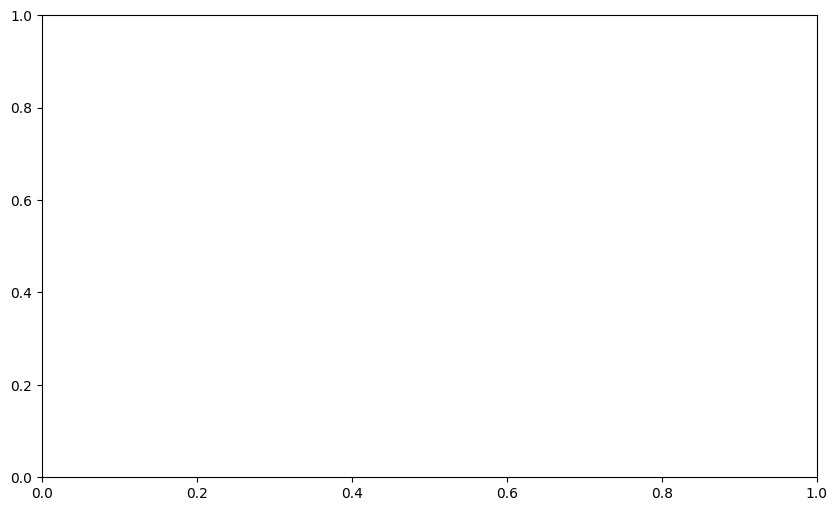

In [32]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/sim_X.npy")
Y = np.load(file_path + "/sim_Y.npy")

sou_snr = 22
tar_snr = 10

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 3
lr = 0.001
n_snr = 4
offset_snr = 4

import torch
import torch.nn as nn

for i in range(n_snr-1):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_mcd, t_mcd = mcd.Mcd(G=MCD_G, C=MCD_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)

    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=CLDNN_FA, LP=CLDNN_LP, DC=CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=STAR_G, C=STAR_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)

    tar_snr += offset_snr

x = np.arange(1, 5)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

"""
for i in range(n_snr):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=25, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)
    
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    
    tar_snr += offset_snr
"""

3


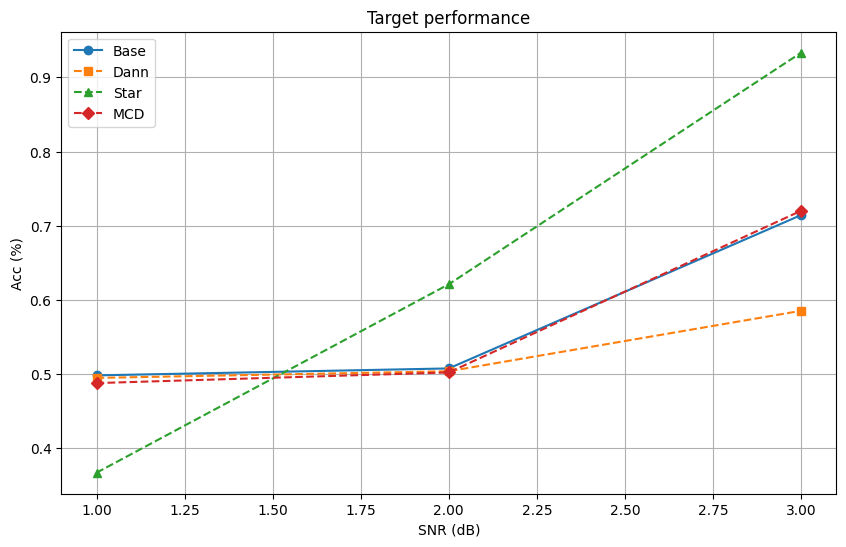

In [35]:
x = np.arange(1, 4)
print(len(s_base_acc))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()


x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()